In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('dfnew_clean.csv')


In [2]:
target = ['Close']
features = ['Transaction','Open', 'High', 'Low']
df = stock_data[features + target]

In [3]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])


In [4]:
# extract the input sequences and output values
sequence_length = 5

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

In [19]:
# build and train the model
model = Sequential()
model.add(LSTM(units=25, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 25)             3100      
                                                                 
 dropout_7 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 50)             15200     
                                                                 
 dropout_8 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
31/31 [==============================] - 3s 13ms/step - loss: 0.0333
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0021
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0013
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0010
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 8/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0010
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 9.7585e-04
Epoch 11/50
31/31 [==============================] - 0s 12ms/step - loss: 8.8464e-04
Epoch 12/50
31/31 [==============================] - 0s 12ms/step - loss: 8.0514e-04
Epoch 13/50
31/31 [======

In [21]:
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index()
test

,index,DateTime,Open,Close,Predicted
0,1966,2021-01-08,580.0,580.0,521.657776
1,1967,2021-01-11,577.0,584.0,528.533569
2,1968,2021-01-12,583.0,591.0,536.058167
3,1969,2021-01-13,595.0,605.0,543.865784
4,1970,2021-01-14,587.0,592.0,550.106018
5,1971,2021-01-15,621.0,601.0,556.322876
6,1972,2021-01-18,608.0,607.0,559.929871
7,1973,2021-01-19,618.0,627.0,564.233582
8,1974,2021-01-20,633.0,647.0,567.887695
9,1975,2021-01-21,640.0,673.0,570.540405


In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

test.loc[test.Close.shift(1) >= test.Close, "Trend"]= 0
test.loc[test.Close.shift(1) < test.Close, "Trend"]= 1
test['Trend']=test['Trend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Predicted, "PredTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Predicted, "PredTrend"]= 1
test['PredTrend']=test['PredTrend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Close.shift(1), "PredvsTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Close.shift(1), "PredvsTrend"]= 1
test['PredvsTrend']=test['PredvsTrend'].fillna(0).astype(int)


test['status'] = test.PredTrend.shift(1).fillna(0).astype(int)
test['status2']=test.status
test.loc[( (test.status.shift(1)==0) & (test.status==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 0
test.loc[( (test.status.shift(1)==1) & (test.status==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 1
# test['status2']=test['status2'].fillna(0).astype(int)
# test['status2']=test['status2']

# 做一條predict的均線試看看

test['status3']= test.PredvsTrend.shift(1).fillna(0).astype(int)
test.loc[( (test.PredvsTrend.shift(1)==0) & (test.PredvsTrend==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 0
test.loc[( (test.PredvsTrend.shift(1)==1) & (test.PredvsTrend==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 1



# .shift(1)是前一個

test['buy_cost'] = test.Open[np.where((test.status3 == 1) * (test.status3.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status3 == 0) * (test.status3.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

test

,index,DateTime,Open,Close,Predicted,Trend,PredTrend,PredvsTrend,status,status2,status3,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity
0,1966,2021-01-08,580.0,580.0,521.657776,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,1967,2021-01-11,577.0,584.0,528.533569,1,1,1,0,0,0,0.0,0.0,0.000000,0.000000,-0.005172,-0.000000,-0.000000,0.994828,1.000000,1.000000
2,1968,2021-01-12,583.0,591.0,536.058167,1,1,1,1,1,1,583.0,0.0,0.000000,0.000000,0.010399,0.000000,0.000000,1.005172,1.000000,1.000000
3,1969,2021-01-13,595.0,605.0,543.865784,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,0.020583,0.020583,0.020583,1.025862,1.020583,1.020583
4,1970,2021-01-14,587.0,592.0,550.106018,0,1,1,1,1,1,0.0,0.0,0.000000,0.000000,-0.013445,-0.013445,-0.013445,1.012069,1.006861,1.006861
5,1971,2021-01-15,621.0,601.0,556.322876,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,0.057922,0.057922,0.057922,1.070690,1.065180,1.065180
6,1972,2021-01-18,608.0,607.0,559.929871,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,-0.020934,-0.020934,-0.020934,1.048276,1.042882,1.042882
7,1973,2021-01-19,618.0,627.0,564.233582,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,0.016447,0.016447,0.016447,1.065517,1.060034,1.060034
8,1974,2021-01-20,633.0,647.0,567.887695,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,0.024272,0.024272,0.024272,1.091379,1.085763,1.085763
9,1975,2021-01-21,640.0,673.0,570.540405,1,1,1,1,1,1,0.0,0.0,0.000000,0.000000,0.011058,0.011058,0.011058,1.103448,1.097770,1.097770


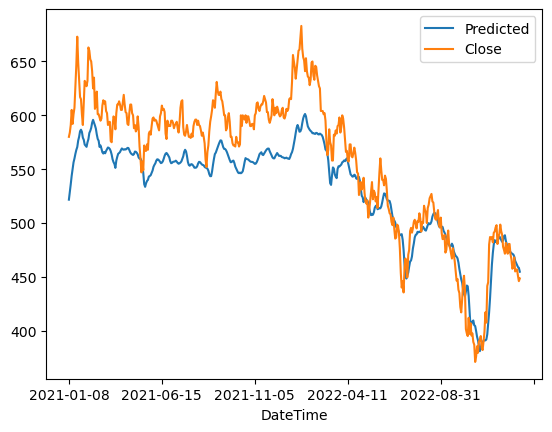

In [23]:
plot=test.plot(x='DateTime',y=['Predicted','Close'])
fig = plot.get_figure()

Text(0, 0.5, 'strategy_equity')

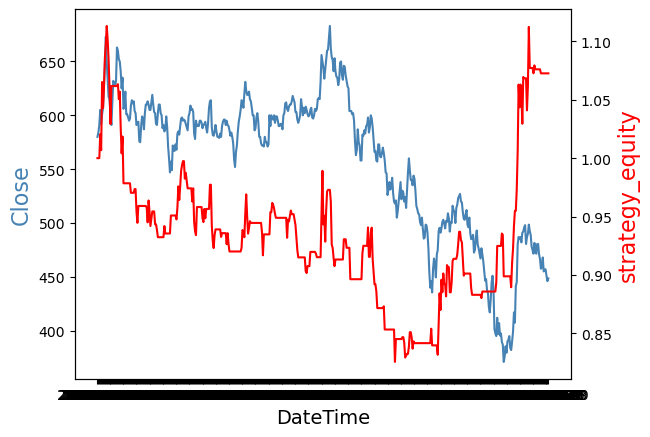

In [24]:
col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_equity, color=col2)
ax2.set_ylabel('strategy_equity', color=col2, fontsize=16)

In [25]:
# 如果train的結果很好再存
# model.save('BEST-2.h5')
# fig2.savefig("BEST-2.png")